### Predicting Customer Attrition with Survival Analysis
------------
#### <b>1. Objective <b>
* Customer Attrition or Churn refers to a decision made by the customer about ending the business relationship. 
* Customer loyalty and customer churn always add up to 100%. If a firm has a 60% of loyalty rate, then their loss or churn rate of customers is 40%.
* Churn is undesirable and it is the firm's responsibility to understand why customers are churning and prevent that 
--------
#### <b>2. Approach <b>
* Usually when it comes to Predicting customer churn, we look at classification techniques such as Logistic regression but the problem with that approach is that it doesn't take time into consideration
* So we will be using a tool from an unlikely place - Survival analysis. It was first developed by actuaries & medical professionals to predict survival rates
* Here we will be defining -
    - Birth event: For eg, a customer subsribing to your product or service
    - Death event: For eg, a customer ending the relationship with the company
    
* Component that makes SA superior to other models is its ability to deal with "censorship" in data
* Censorship basically refers to losing track of a customer or the customer "not dying" before the end of the observation period
* This data is considered "censored" since everyone dies eventually, we are just missing the data
* Similarly, we would expect to lose all customers eventually. Just because we haven't observed them cancelling their subscription doesn't mean they never will.

We have all come across "Teleco Customer Churn" dataset which we usually use to Predict customer churn by binary classification method. <br>
Now, we will use the same dataset and apply our newly learnt Survival analysis skills.

---------------------

#### <b> 3. Data Preparation <b>

<b> 3.1 - Import necessary libs and read data 

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lifelines

churn_data = pd.read_csv('../data/Telco-Customer-Attrition-Data.csv')
churn_data.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


<b>3.2 - Cleaning the dataset <b>
    
For each customer, we will need to calculate the following
* Tenure: How long has the customer been with the firm?
* Churn: Has the customer left the firm?

In [18]:
# Transform tenure and churn features
churn_data['tenure'] = churn_data['tenure'].astype(float)
churn_data['Churn'] = churn_data['Churn'] == 'Yes'
churn_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1.0,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,False
1,5575-GNVDE,Male,0,No,No,34.0,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,False
2,3668-QPYBK,Male,0,No,No,2.0,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,True
3,7795-CFOCW,Male,0,No,No,45.0,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,False
4,9237-HQITU,Female,0,No,No,2.0,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,True


Note: Many customers in our data have not left yet. Here we deal with censorship as discussed earlier.

---------

#### <b> 4. Exploratory Data Analysis

Let's look at survival rate for the average customer using a Kaplan-Meier survival curve. We will fit a KM survival curve to our dataset & plot our survival curve with confidence interval.


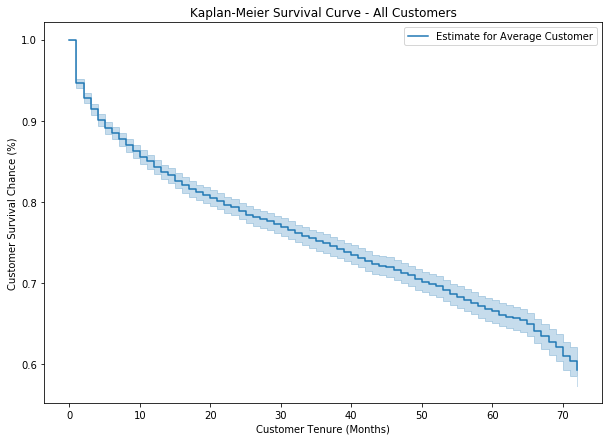

In [19]:
# fitting kmf to churn data
t = churn_data['tenure'].values
churn = churn_data['Churn'].values
kmf = lifelines.KaplanMeierFitter()
kmf.fit(t, event_observed=churn, label='Estimate for Average Customer')

# plotting kmf curve
fig, ax = plt.subplots(figsize=(10,7))
kmf.plot(ax=ax)
ax.set_title('Kaplan-Meier Survival Curve - All Customers')
ax.set_xlabel('Customer Tenure (Months)')
ax.set_ylabel('Customer Survival Chance (%)')
plt.show()

Note: Survival curve is cumulative. After 20 months, the chance of a customer not canceling service is just above 80%

Insights:
* We can see that even after 70 months, the company is able to retain 60% of its customers
* Churn is relatively low when it comes to Telcos

Now we will examine the affect of different features on the survival rate. <br>
For this we will use "Cox Proportional Hazards Model", we can also think of this as a Survival Regression Model

* Hazards can be something that would increase or decrease the chances of survival. In our case, a hazard can be type of contract. 
* Customer with multi-year contracts would probably cancel less frequently than those with monthly contracts
* Restriction - Here the model assumes a constant ratio of hazards over time across groups.
* Lifelines offers a check_assumptions method for CoxPHFitter Object

<b> 4.1 - Data cleaning, encoding categorical variables (k-1 dummies)

In [20]:
features_to_drop = ['customerID', 'gender', 'PhoneService', 'InternetService']

# engineering numeric columns for Cox Proportional Hazard estimation
churn_hazard = churn_data.drop(features_to_drop, axis=1).copy()

# convert some stuff to integers
churn_hazard['TotalCharges'] = pd.to_numeric(churn_hazard['TotalCharges'], errors='coerce')
churn_hazard['TotalCharges'].fillna(0, inplace=True)

# a lot of variables are encoded as 'Yes' or 'No', lets get these all done at once
binary_features = ['Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                   'StreamingTV','StreamingMovies', 'PaperlessBilling']
for feat in binary_features:
    churn_hazard[feat] = churn_hazard[feat] == 'Yes'
    
# let's one hot encode the remaining categorical features
ohe_features = ['MultipleLines', 'Contract', 'PaymentMethod']
churn_hazard = pd.get_dummies(churn_hazard, 
                              drop_first=True,
                              columns=ohe_features)

In [21]:
churn_hazard.head()

,SeniorCitizen,Partner,Dependents,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,...,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,True,False,1.0,False,True,False,False,False,False,...,29.85,29.85,False,1,0,0,0,0,1,0
1,0,False,False,34.0,True,False,True,False,False,False,...,56.95,1889.50,False,0,0,1,0,0,0,1
2,0,False,False,2.0,True,True,False,False,False,False,...,53.85,108.15,True,0,0,0,0,0,0,1
3,0,False,False,45.0,True,False,True,True,False,False,...,42.30,1840.75,False,1,0,1,0,0,0,0
4,0,False,False,2.0,False,False,False,False,False,False,...,70.70,151.65,True,0,0,0,0,0,1,0


---------

#### <b> 5. Modeling

In [22]:
# Fitting survival regression model 
cph = lifelines.CoxPHFitter()
cph.fit(churn_hazard, duration_col='tenure', event_col='Churn', show_progress=False)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -12688.70
         time fit was run = 2021-06-15 09:14:33 UTC

---
                                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                     
SeniorCitizen                           0.03       1.03       0.06            -0.08             0.14                 0.93                 1.16
Partner                                -0.19       0.82       0.06            -0.30            -0.09                 0.74                 0.92
Dependents                             -0.10       0.91       0.07            -0.23             0.04                 0.79                 1.04
OnlineSecurity                         -0.38       0.68       0.07            -0.51            -0.25                 0.60                 0.78
OnlineBackup                           -0.29       0.75       0.06            -0.40            -0.18                 0.67                 0.83
DeviceProtection                       -0.16       0.85       0.06            -0.27            -0.05                 0.76                 0.95
TechSupport                            -0.28       0.76       0.07            -0.41            -0.15                 0.67                 0.86
StreamingTV                            -0.27       0.77       0.06            -0.38            -0.15                 0.68                 0.86
StreamingMovies                        -0.26       0.77       0.06            -0.38            -0.14                 0.69                 0.87
PaperlessBilling                        0.16       1.17       0.06             0.05             0.27                 1.05                 1.31
MonthlyCharges                          0.07       1.07       0.00             0.06             0.07                 1.06                 1.07
TotalCharges                           -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
MultipleLines_No phone service          0.64       1.89       0.12             0.41             0.87                 1.51                 2.38
MultipleLines_Yes                      -0.20       0.82       0.05            -0.30            -0.09                 0.74                 0.91
Contract_One year                      -1.40       0.25       0.10            -1.60            -1.20                 0.20                 0.30
Contract_Two year                      -4.05       0.02       0.20            -4.43            -3.66                 0.01                 0.03
PaymentMethod_Credit card (automatic)  -0.01       0.99       0.09            -0.18             0.17                 0.83                 1.19
PaymentMethod_Electronic check          0.38       1.46       0.07             0.24             0.52                 1.27                 1.69
PaymentMethod_Mailed check              0.52       1.68       0.09             0.35             0.69                 1.42                 1.99

                                           z      p   -log2(p)
covariate                                                     
SeniorCitizen                           0.60   0.55       0.87
Partner                                -3.52 <0.005      11.20
Dependents                             -1.39   0.17       2.60
OnlineSecurity                         -5.65 <0.005      25.89
OnlineBackup                           -5.22 <0.005      22.41
DeviceProtection                       -2.85 <0.005       7.85
TechSupport                            -4.19 <0.005      15.15
StreamingTV                            -4.46 <0.005      16.86
S

* In the above regression, the key output is exp(coef). This is interpreted as the scaling of hazard risk for each additional unit of the variable, 1.00 being neutral.
* For example, the last exp(coefficient), corresponding to PaymentMethod_Mailed check, means a customer that pays by mailing a check is 1.68 times as likely to cancel their service.
* For the company, exp(coef) below 1.0 is good, meaning a customer less likely to cancel.

To better visualize the above, we can plot the coefficient outputs and their confidence intervals.

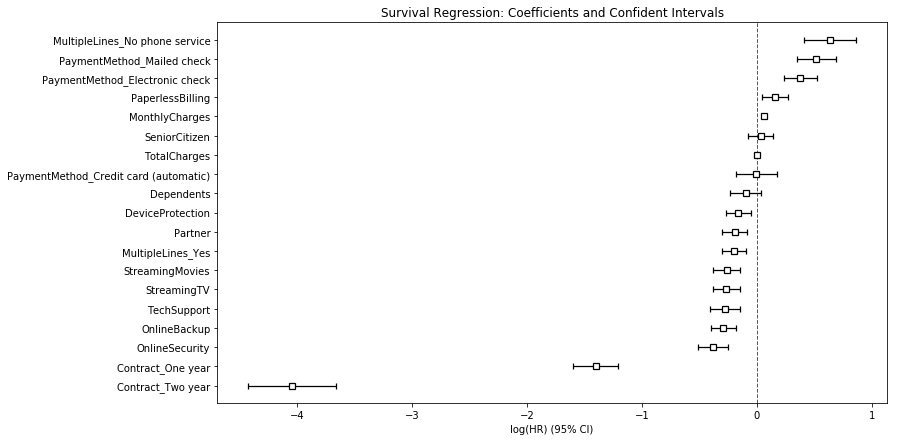

In [23]:
# plotting coefficients
fig_coef, ax_coef = plt.subplots(figsize=(12,7))
ax_coef.set_title('Survival Regression: Coefficients and Confident Intervals')
cph.plot(ax=ax_coef);

In [24]:
# function for creating Kaplan-Meier curve plots segmented
# by categorical variables
def plot_categorical_survival(feature, t='tenure', event='Churn', df=churn_data, ax=None):
    for cat in df[feature].unique():
        idx = df[feature] == cat
        kmf = lifelines.KaplanMeierFitter()
        kmf.fit(df[idx][t], event_observed=df[idx][event], label=cat)
        kmf.plot(ax=ax, label=cat)

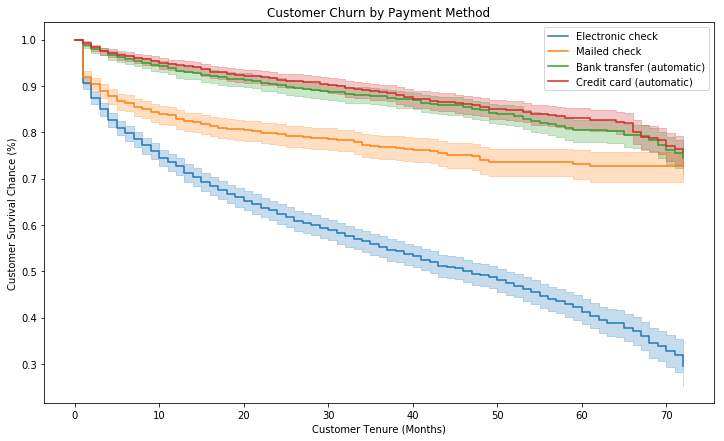

In [25]:
fig_pmt, ax_pmt = plt.subplots(figsize=(12,7))
plot_categorical_survival(feature='PaymentMethod', ax=ax_pmt)
ax_pmt.set_title('Customer Churn by Payment Method')
ax_pmt.set_xlabel('Customer Tenure (Months)')
ax_pmt.set_ylabel('Customer Survival Chance (%)')
plt.show()

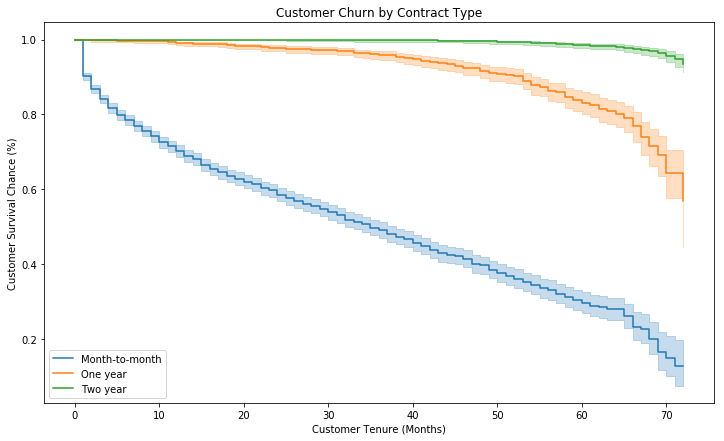

In [26]:
fig_contract, ax_contract = plt.subplots(figsize=(12,7))
plot_categorical_survival(feature='Contract', ax=ax_contract)
ax_contract.set_title('Customer Churn by Contract Type')
ax_contract.set_xlabel('Customer Tenure (Months)')
ax_contract.set_ylabel('Customer Survival Chance (%)')
plt.show()


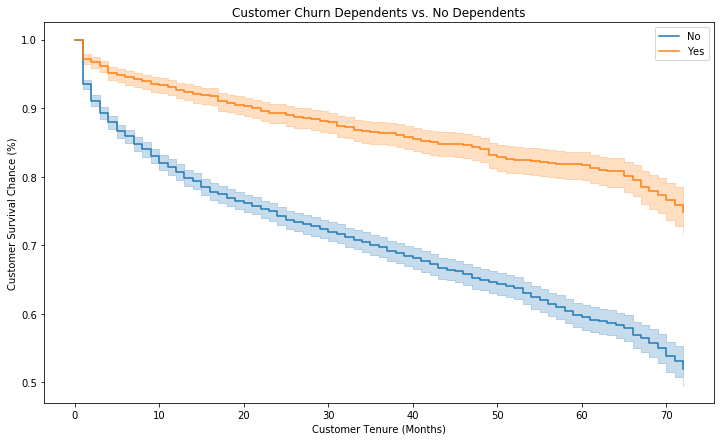

In [27]:

fig_dep, ax_dep = plt.subplots(figsize=(12,7))
plot_categorical_survival(feature='Dependents', ax=ax_dep)
ax_dep.set_title('Customer Churn Dependents vs. No Dependents')
ax_dep.set_xlabel('Customer Tenure (Months)')
ax_dep.set_ylabel('Customer Survival Chance (%)')
plt.show()

---------

#### <b> 6. Recommendations
    
So coming back to our objective, how can we reduce attrition?

Customer Specification:  
* The most important feature, by far, is the presence of a 1 or 2 year contract. Customers are .25 and .02, respectively, times as likely to cancel their service if they are under contract. Cancellation fees are a possible underlying cause. As long as these fees do not prohibit new sales, we would recommend continuing to put them into as many contracts as possible.

Customer Selection:
* Customers with a partner or dependents are .82 and .91 times as likely to cancel as normal customers. Families and other large households seem to be less likely to change providers. This could be due to higher incomes, less time to consider options, or another combination of factors.
    
Payment Systems:
* There is a reason companies now default to opting employees into 401k plans. It takes effort for people to make a change, even if it is beneficial.
* Make sure your customer's default is an automatic payment made monthly. This requires little effort from the customer to remain subscribed.
* Conversely, sending a check, in the mail or electronically, is a pain. It requires effort to remain subscribed.
    
--------------------

<b> Links: <b>

* Portfolio : https://gofornaman.github.io
* LinkedIn : https://www.linkedin.com/in/naman-doshi/

------------